<a href="https://colab.research.google.com/github/pudovikoff/Experiments_tg/blob/main/Pythia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correllation between Pythia, ETH, BTC in daily returns.

This notebook download and analyze daily price changes in Pythia, ETH and BTC prices.

In [ ]:
# Install and load required packages
install.packages(c("httr", "jsonlite", "dplyr", "xts"))
install.packages(c("ggplot2", "reshape2"))

library(httr)
library(jsonlite)
library(dplyr)
library(xts)
library(ggplot2)
library(reshape2)

In [2]:
# Fetch historical data function
get_historical_data <- function(crypto_id, vs_currency = "usd", days = "180") {
  url <- paste0("https://api.coingecko.com/api/v3/coins/", crypto_id, "/market_chart")
  response <- GET(url, query = list(vs_currency = vs_currency, days = days))
  data <- fromJSON(content(response, "text"))
  return(data$prices)
}

# Convert historical price data to daily returns
get_daily_returns <- function(prices) {
  # Convert list to a data frame
  prices_df <- as.data.frame(prices)
  colnames(prices_df) <- c("timestamp", "price")
  prices_df$timestamp <- as.POSIXct(prices_df$timestamp / 1000, origin = "1970-01-01")

  # Calculate daily returns
  prices_df$daily_return <- c(NA, diff(prices_df$price) / head(prices_df$price, -1))

  # Remove NA values
  prices_df <- na.omit(prices_df)

  # Convert to xts format (time series data)
  prices_xts <- xts(prices_df$daily_return, order.by = prices_df$timestamp)

  return(prices_xts)
}

# Fetch historical data for BTC, ETH, and PYTHIA
btc_prices <- get_historical_data("bitcoin")
eth_prices <- get_historical_data("ethereum")
pythia_prices <- get_historical_data("pythia")  # Assuming Pythia is available

# Convert to daily returns
btc_returns <- get_daily_returns(btc_prices)
eth_returns <- get_daily_returns(eth_prices)
pythia_returns <- get_daily_returns(pythia_prices)

# Merge the returns data by date
combined_returns <- merge(btc_returns, eth_returns, pythia_returns, all = FALSE)
colnames(combined_returns) <- c("BTC", "ETH", "PYTHIA")

# Calculate the correlation matrix of the daily returns
correlation_matrix <- cor(combined_returns)

# Print the correlation matrix
print(correlation_matrix)


             BTC       ETH    PYTHIA
BTC    1.0000000 0.7580616 0.1950163
ETH    0.7580616 1.0000000 0.2016643
PYTHIA 0.1950163 0.2016643 1.0000000


In [4]:
combined_returns

                     BTC          ETH       PYTHIA
2025-01-06  1.097642e-03 -0.006699594  0.000000000
2025-01-07  3.929061e-02  0.014106646  0.131967101
2025-01-08 -5.162210e-02 -0.083295778 -0.224739939
2025-01-09 -1.996227e-02 -0.016239868  0.200442066
2025-01-10 -2.778920e-02 -0.031889635 -0.190431646
2025-01-11  2.555148e-02  0.015558157  0.635437657
2025-01-12 -1.869130e-03  0.004409468 -0.133454148
2025-01-13 -1.108093e-03 -0.005944818 -0.175236787
2025-01-14  1.671147e-05 -0.039680182  0.074886613
2025-01-15  2.242018e-02  0.028791549 -0.220202650
2025-01-16  3.871717e-02  0.068913841  0.005709245
2025-01-17 -2.677347e-03 -0.039914730  0.065840897
2025-01-18  4.114280e-02  0.050714724 -0.026555248
2025-01-19  1.669749e-03 -0.048366686 -0.322756643
2025-01-20 -2.932180e-02 -0.030510724 -0.510454906
2025-01-21  4.834064e-03  0.017123126  1.544977893
2025-01-22  4.340719e-02  0.019294307 -0.046584994
2025-01-23 -2.362638e-02 -0.026677123  0.379450062
2025-01-24  3.801113e-03  0.029

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


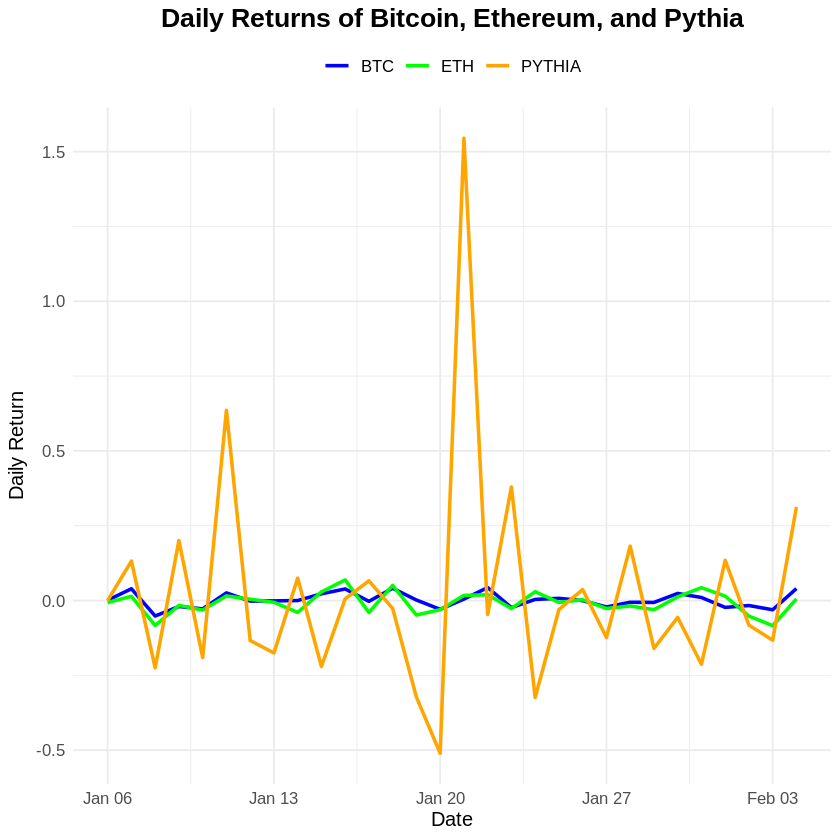

In [3]:
# Convert combined returns to a data frame suitable for ggplot
returns_df <- data.frame(Date = index(combined_returns), coredata(combined_returns))

# Reshape data from wide to long format
returns_long <- melt(returns_df, id.vars = "Date", variable.name = "Asset", value.name = "Daily_Return")

# Create the plot using ggplot
ggplot(returns_long, aes(x = Date, y = Daily_Return, color = Asset)) +
  geom_line(size = 1) +  # Line plot with a thick line
  theme_minimal() +  # Minimalist theme
  labs(title = "Daily Returns of Bitcoin, Ethereum, and Pythia",
       x = "Date",
       y = "Daily Return") +
  scale_color_manual(values = c("BTC" = "blue", "ETH" = "green", "PYTHIA" = "orange")) +  # Custom colors for each asset
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),  # Center the title and customize font
    axis.title = element_text(size = 12),  # Customize axis titles
    axis.text = element_text(size = 10),  # Customize axis labels
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 10)  # Customize legend text
  ) +
  theme(legend.position = "top")  # Position the legend at the top


## Conslusion

The correlation between ETH and BTC is more than 0.75, so they might be correlated.

The correlation between Pythia and BTC \ ETH is around 0.2, so it is a too small value to make any conclusions. But Pythia is signifacantly more volatily than the other two tokens.

